# 時系列データに対する検定(python実装版)

- 松浦健太郎氏のブログ記事<http://statmodeling.hatenablog.com/entry/difference-between-time-courses>にある時系列データ間の差の有無に関する検定手法を、python+pystanで行ったもの。
- 公開するほどのものでもないが、諸般の事情から仮置きする。

## 1. 必要なライブラリのインポート

In [1]:
import numpy as np
import pandas as pd
from pystan import StanModel
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

In [2]:
# エラーバーの設定
import matplotlib
matplotlib.rcParams.update({'errorbar.capsize': 2})

## 2. 使用するデータの作成

- サイン波にノイズを加えた時系列データを作り、それに差分を加えたデータも作成する。
- 元のRコードは以下

- これをpythonで実行する。

In [3]:
np.random.seed(1)

n_time = 24
n0 = 100
n1 = 10
add_y = 0.3
add_x = np.arange(6, 12)
sd = 0.3

x = np.arange(1, n_time+1)
y0 = np.sin(x / n_time*2*np.pi)
y1 = y0.copy()
y1[add_x] += add_y

Y0 = np.round(a = np.random.normal(loc=y0, scale=sd, size=(n0, n_time)), decimals=3)
Y1 = np.round(a = np.random.normal(loc=y1, scale=sd, size=(n1, n_time)), decimals=3)
#d = pd.concat([pd.DataFrame(Y0), pd.DataFrame(Y1)], axis=0)

- 作成されたデータ

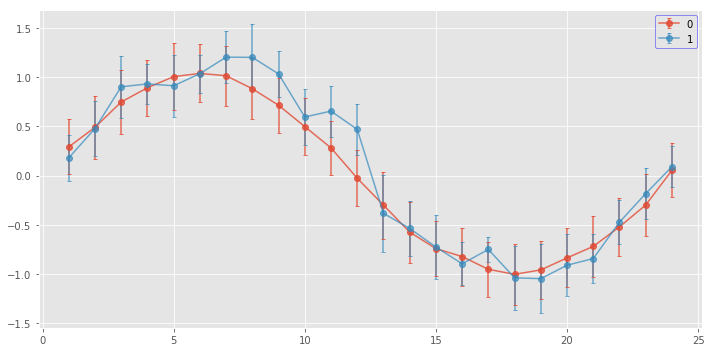

In [4]:
plt.figure(figsize=(10,5))
plt.errorbar(x = x, y = Y0.mean(axis=0), yerr = Y0.std(axis=0), fmt = "-o", label="0", alpha=0.8)
plt.errorbar(x = x, y = Y1.mean(axis=0), yerr = Y1.std(axis=0), fmt = "-o", label="1", alpha=0.7)
plt.legend(frameon = True, edgecolor= "b")
plt.tight_layout()

## 3. モデルの作成

- ブログ記事の「モデル２」を用いる。
  - 正常データのシステムモデルには2階差分を仮定する    
  
    $\mu[t] = Normal(2\mu[t-1]-\mu[t-2], \sigma_\mu^2) $  
    $Y_0[t] = Normal(\mu[t], \sigma_Y^2) $  
    
    $\delta[t] = Cauchy(\delta[t-1], \sigma_\delta) $  
    $Y_1[t] = Normal(\mu[t]+\delta[t], \sigma_Y^2) $  

In [5]:
stancode = """
data {
  int N_time;
  int N0;
  int N1;
  int X[N_time];
  vector[N_time] Y0[N0];
  vector[N_time] Y1[N1];
}

parameters {
  vector[N_time] mu;
  real di0;
  vector<lower=-pi()/2, upper=pi()/2>[N_time-1] di_unif;
  real<lower=0> s_mu;
  real<lower=0> s_di;
  real<lower=0> s_Y;
}

transformed parameters {
  vector[N_time] di;
  vector[N_time] y1_mean;
  di[1] <- di0;
  for (t in 2:N_time)
    di[t] <- di[t-1] + s_di*tan(di_unif[t-1]);
  y1_mean <- mu + di;
}

model {
  for (t in 3:N_time)
    mu[t] ~ normal(2*mu[t-1] - mu[t-2], s_mu);
  for (n in 1:N0)
    Y0[n] ~ normal(mu, s_Y);
  for (n in 1:N1)
    Y1[n] ~ normal(y1_mean, s_Y);
}

"""

In [6]:
# コンパイル済みのモデルがあれば読み込み。なければコンパイルし保存。
try:
    with open('./model2.pkl', "rb") as f:
        stanmodel = pickle.load(f)
except FileNotFoundError:
    stanmodel = StanModel(model_code=stancode, model_name="model2")
    with open('./model2.pkl', "wb") as f:
        pickle.dump(stanmodel, f)

## 4. MCMC実行

In [7]:
#pystan用にデータを辞書型にまとめる
standata = {"N_time":n_time, "N0":n0, "N1":n1, "X":x, "Y0":Y0, "Y1":Y1}

In [8]:
#sampling実行
fit = stanmodel.sampling(data = standata, iter=1500, warmup=500, seed=123, init=lambda : dict(mu=Y0.mean(axis=0)))

//anaconda/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


## 5. 結果

### 5.1. MCMCの結果

In [9]:
# fit.summary()をDataFrameに整形する
fit_summary = pd.DataFrame(data = fit.summary()["summary"], index = fit.summary()["summary_rownames"], 
                          columns= fit.summary()["summary_colnames"])
fit_summary.head(n_time)

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
mu[0],0.283085,0.000443,0.027993,0.228844,0.264798,0.282423,0.301391,0.340118,4000.0,0.999965
mu[1],0.504429,0.000381,0.024108,0.457112,0.488194,0.504376,0.521053,0.550784,4000.0,0.999588
mu[2],0.740793,0.000382,0.024145,0.694058,0.724373,0.740646,0.756854,0.788379,4000.0,0.999805
mu[3],0.895994,0.000380,0.024010,0.846697,0.881088,0.896324,0.911941,0.942797,4000.0,1.000300
mu[4],0.995485,0.000370,0.023403,0.948732,0.980074,0.995494,1.011701,1.040778,4000.0,0.999547
mu[5],1.035130,0.000372,0.023511,0.988928,1.019079,1.035159,1.051098,1.081715,4000.0,1.000010
mu[6],1.007501,0.000384,0.024301,0.960726,0.990833,1.007038,1.023447,1.056244,4000.0,0.999468
mu[7],0.890440,0.000380,0.024023,0.843760,0.874524,0.890116,0.906185,0.937188,4000.0,0.999380
mu[8],0.715590,0.000373,0.023588,0.668658,0.699926,0.715175,0.730983,0.762976,4000.0,0.999524
mu[9],0.497292,0.000382,0.024179,0.448125,0.481261,0.497278,0.513877,0.543044,4000.0,0.999393


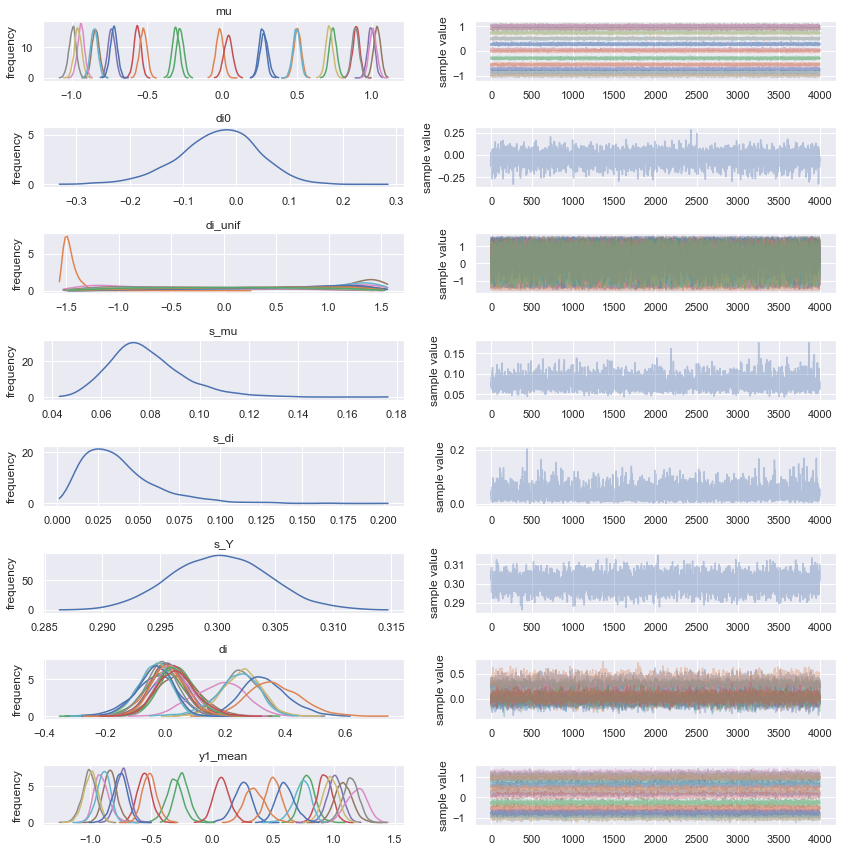

In [10]:
# 事後分布およびトレースプロットの確認
sns.set(rc={"figure.figsize":(12,12)}) # サイズの調整に必要
fit.plot()
plt.tight_layout()

### 5.2. 推定された潜在変数mu

In [11]:
ms = fit.extract()

In [12]:
mu_df = pd.DataFrame(data=ms["mu"])

In [13]:
mu_df = mu_df.unstack().to_frame().reset_index().astype(dtype=np.float64)
mu_df["level_0"] += 1
mu_df.rename(columns={0:"value"}, inplace=True)

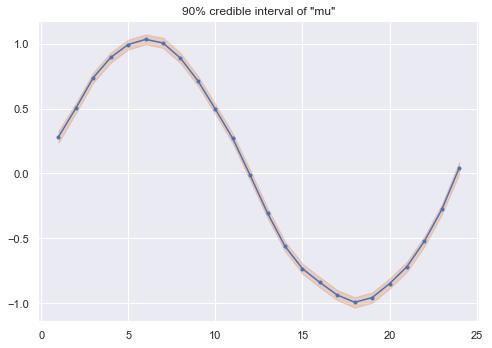

In [14]:
sns.set(rc={"figure.figsize":(7,5)})#; plt.style.use('ggplot')
plt.plot(mu_df["level_0"].unique(), mu_df.groupby('level_0').mean()["value"], color="C0", marker=".")
plt.fill_between(mu_df["level_0"].unique(), mu_df.groupby('level_0').quantile(0.05)['value'], 
                 mu_df.groupby('level_0').quantile(0.95)["value"], alpha=0.3, color="C1")
plt.title('90% credible interval of "mu"')
plt.tight_layout()

   - 潜在変数muは概ねサインカーブを描いており，真の値に近い推定結果が得られている。

### 5.3. 時系列の差分di

In [15]:
di_df = pd.DataFrame(data=ms["di"])

In [16]:
di_df = di_df.unstack().to_frame().reset_index().astype(dtype=np.float64)
di_df["level_0"] += 1
di_df.rename(columns={0:"value"}, inplace=True)

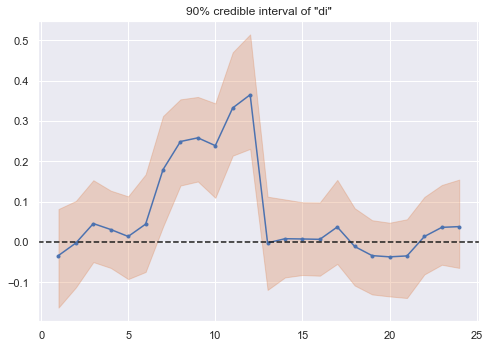

In [17]:
plt.plot(di_df["level_0"].unique(), di_df.groupby('level_0').mean()["value"], color="C0", marker=".")
plt.fill_between(di_df["level_0"].unique(), di_df.groupby('level_0').quantile(0.05)['value'], 
                 di_df.groupby('level_0').quantile(0.95)["value"], alpha=0.3, color="C1")
plt.axhline(0, color="k", linestyle="--")
plt.title('90% credible interval of "di"')
plt.tight_layout()

   - 時刻7~12にかけて，差分diの90％信用区間が0.0を含んでいない。
       - この期間に何らかの変化があった，と考えるのが自然である。